In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, confusion_matrix
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime

import json
import ast
import eli5
import shap

from eli5.sklearn import PermutationImportance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import *
import gc
from catboost import CatBoostClassifier
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats

from sklearn.ensemble import RandomForestClassifier

In [2]:
# Lets import our data
target = pd.read_csv('target.csv')
data = pd.read_csv('data.csv')
test = pd.read_csv('test.csv')
vdata = pd.read_csv('vdata.csv')
vtarget = pd.read_csv('vtarget.csv')
ltarget = pd.read_csv('ltarget.csv', header=None)
lvtarget = pd.read_csv('lvtarget.csv', header=None)
wdata = pd.read_csv('whole_data.csv')
wtarget = pd.read_csv('whole_target.csv', header=None)

winedata = pd.read_csv('winedata.csv')

ccdata = pd.read_csv('creditcard.csv')

irisdata = pd.read_csv('irisdata.csv')
iristarget = pd.read_csv('iristarget.csv')

print('Data is ready!')

Data is ready!


In [3]:
# Lets go ahead and set up our data. First lets make our target and drop it from wine.
winetarget = winedata['quality']
winedata = winedata.drop('quality', axis=1)

# Lets trim off time and amount from ccdata as those are independent features we don't want the model to learn.
cctarget = ccdata['Class']
ccdata = ccdata.drop(['Time','Amount', 'Class'], axis=1)

iristarget = iristarget['target']

target = target['surface']
vtarget = vtarget['surface']
ltarget = ltarget[0]
lvtarget = lvtarget[0]
wdata = wdata.drop(['series_id', 'group_id', 'surface'], axis=1)
wtarget = wtarget[0]

irisd, id_test, irist, it_test = train_test_split(irisdata, iristarget, test_size=0.33, random_state=42)
wined, wd_test, winet, wt_test = train_test_split(winedata, winetarget, test_size=0.33, random_state=42)
ccd, ccd_test, cct, cct_test = train_test_split(ccdata, cctarget, test_size=0.33, random_state=42)

In [4]:
# Now lets make sure our train and target variables are even for every dataset
print(irisdata.shape)
print(iristarget.shape)

print(winedata.shape)
print(winetarget.shape)

print(ccdata.shape)
print(cctarget.shape)

print(target.shape)
print(vtarget.shape)
print(ltarget.shape)
print(lvtarget.shape)
print(wtarget.shape)
print(wdata.shape)
print(vdata.shape)
print(data.shape)
test.shape

(150, 4)
(150,)
(6497, 11)
(6497,)
(284807, 28)
(284807,)
(2804,)
(1006,)
(358912,)
(128768,)
(487680,)
(487680, 23)
(128768, 23)
(358912, 23)


(488448, 23)

In [37]:
# Just like in our other notebooks we are going to SMOTE the ccdata
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy=0.5, random_state=2)

ccd_SMOTE, cct_SMOTE = sm.fit_resample(ccd,cct)

ccd_SMOTE = pd.DataFrame(ccd_SMOTE, columns=ccd.columns)

In [38]:
# Lets see how many new minority samples there are.
print(len(cct))
len(cct_SMOTE)

190820


285715






Below are the docs for both as well as some introductionary tutorials.

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

https://xgboost.readthedocs.io/en/latest/

https://www.kaggle.com/pintu161/implementation-of-lightgbm-for-begineers

https://xgboost.readthedocs.io/en/latest/tutorials/model.html

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [34]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)

In [35]:
params = {'num_leaves': 123,
          'min_data_in_leaf': 12,
          'objective': 'binary',
          'max_depth': 22,
          'learning_rate': 0.04680350949723872,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8933018355190274,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.9498109326932401,
          'reg_lambda': 0.8058490960546196,
          "num_class": 9,
          'nthread': -1,
          'min_split_gain': 0.009913227240564853,
          'subsample': 0.9027358830703129
         }


In [36]:
model = lgb.LGBMClassifier(**params, n_estimators = 20000, n_jobs = -1)
model.fit(data, ltarget, eval_set=[(data, ltarget), (vdata, lvtarget)], verbose=5000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[15]	training's multi_logloss: 0.836542	valid_1's multi_logloss: 1.97532


LGBMClassifier(bagging_fraction=0.8933018355190274, bagging_freq=5,
        bagging_seed=11, boosting='gbdt', boosting_type='gbdt',
        class_weight=None, colsample_bytree=1.0, importance_type='split',
        learning_rate=0.04680350949723872, max_depth=22,
        min_child_samples=20, min_child_weight=0.001, min_data_in_leaf=12,
        min_split_gain=0.009913227240564853, n_estimators=20000, n_jobs=-1,
        nthread=-1, num_class=9, num_leaves=123, objective='binary',
        random_state=None, reg_alpha=0.9498109326932401,
        reg_lambda=0.8058490960546196, silent=True,
        subsample=0.9027358830703129, subsample_for_bin=200000,
        subsample_freq=0, verbosity=-1)

In [9]:
eli5.show_weights(model, targets=[0, 1], feature_names=list(data.columns), top=40, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.1575,euler_y
0.1131,orientation_X
0.1108,euler_z
0.0924,angular_velocity_Z
0.0665,euler_x
0.0654,norm_Y
0.0567,norm_X
0.0552,orientation_Z
0.0549,totl_anglr_vel
0.0477,norm_Z


In [42]:
param = {'max_depth':100, 'eta':.001, 'silent':1, 'objective':'binary:logistic', 'num_class':1}

train_data = xgb.DMatrix(data=wined, label=winet)
valid_data = xgb.DMatrix(data=wd_test, label=wt_test)

watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
model = xgb.train(dtrain=train_data, num_boost_round=2000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=param)
y_pred = model.predict(valid_data, ntree_limit=model.best_ntree_limit)

# xgb.plot_importance(model)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(wt_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))




[0]	train-error:0.092831	valid_data-error:0.264336
Multiple eval metrics have been passed: 'valid_data-error' will be used for early stopping.

Will train until valid_data-error hasn't improved in 200 rounds.
[500]	train-error:0.054228	valid_data-error:0.215385
Stopping. Best iteration:
[493]	train-error:0.053998	valid_data-error:0.214452

Accuracy: 78.55%


ValueError: Unable to parse node: 1:[volatile

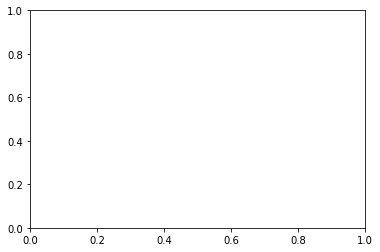

In [47]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')
plt.show()

In [33]:
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# load data
# dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = wined
Y = winet
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=3, random_state=7)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

Accuracy: 77.25%
